# Data & Library importing

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras

Using TensorFlow backend.


In [6]:
import os
import glob
import cv2
import uuid
import datetime

In [7]:

class lampData:
    def __init__(self):
        path= "C:/Users/Surjith/PycharmProjects/opencvburnoutlamps/indData/sceneData/"
        numpy_path = "C:/Users/Surjith/PycharmProjects/opencvburnoutlamps/indData/numpyData/"
        csv_path = "C:/Users/Surjith/PycharmProjects/opencvburnoutlamps/indData/lookup/"
        self.path = path
        self.dataFrame = pd.DataFrame(columns = ['from','to','numpy_file','label','time','brightness','change'])
        self.numpyPath = numpy_path
        self.csvPath = csv_path
        self.seqLength = 0
        self.one_hot_lookup = None
        self.oneHotLookup(12)
        print("Initialized")
    
    def oneHotLookup(self,possibilities):
        self.one_hot_lookup = list()
        possibilities = possibilities
        for i in range(possibilities):
            transition = [0 for _ in range(possibilities)]
            transition[i] = 1
            self.one_hot_lookup.append(transition)   
    
    def getCmdInfo(self):
        badLampIndex = None
        cmdData = None
        with open("cmd.txt") as f:
            contents = f.readlines()
            cmdData = [None]*len(contents)
            i = 0
            
            for content in contents:
                cmdData[i] = content.split('-')
                try:
                    if cmdData[i][5] != "":
                        badLampIndex = int(cmdData[i][5])
                except:
                    continue
                i+=1
        return cmdData,badLampIndex
    
    def getNormalizedImg(self,path):
        rgb = cv2.imread(path)
        hsv = cv2.cvtColor(np.uint8(rgb), cv2.COLOR_BGR2HSV)
        normalizedHSV = (hsv/255.0).astype(np.float32)
        return normalizedHSV
    
    def imgToNumpy(self):
        os.chdir(self.path)
        for session in os.listdir():
            sessionPath = self.path + session + '/fadeData/'
            os.chdir(sessionPath)
            badLampIndex = None
            try:
                cmdData,badLampIndex = self.getCmdInfo()
            except:
                continue
            numberofLamps = len(os.listdir()) - 1
            #print(numberofLamps)
            for lamp in range(numberofLamps):
                lampFolder = sessionPath + str(lamp) +'/'
                lst = os.listdir(lampFolder)
                lst = sorted(lst)[-1]
                numberOfChanges = int(lst.split('_')[0])
                os.chdir(lampFolder)
                for change in range(numberOfChanges):
                    searchString = './%04d*'%(change+1)
                    changeFiles = glob.glob(searchString)
                    if (len(changeFiles)) != 0:
                        sampleImg = self.getNormalizedImg(lampFolder+changeFiles[0])
                        #print(sampleImg.shape)
                        plt.imshow(sampleImg)
                    changeArray = np.array([sampleImg])
                    for changeFile in changeFiles[1:]:
                        sample = self.getNormalizedImg(lampFolder+changeFile)
                        #sample = np.reshape(sample,(1,sample[0],sample[1],sample[2]))
                        
                        changeArray = np.append(changeArray,[sample],axis = 0)
                    uniqueName = str(uuid.uuid4())
                    filename = self.numpyPath +uniqueName +".npy"
                    np.save(filename,changeArray)
                    #print(changeArray.shape, uniqueName)
                    if changeArray.shape[0] > self.seqLength:
                        self.seqLength = changeArray.shape[0]
                    label = None
                    #print(badLampIndex)
                    if badLampIndex != None:
                        label = "Good"
                    else:
                        if lamp == badLampIndex:
                            label = "Bad"
                        else:
                            label = "Good"
                    data = {'from':cmdData[lamp][2],'to':cmdData[lamp][3],'numpy_file':uniqueName,'label':label,'time':cmdData[lamp][1],'brightness':cmdData[lamp][4],'change':change}
                    self.dataFrame = self.dataFrame.append(data,ignore_index = True)
        print("Numpy Export completed!")
        print("Max Length: ", self.seqLength)
                    
    def exportCSV(self):
        self.dataFrame.to_csv(self.csvPath+"lookup"+str(datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))+".csv")
        print("Lookup CSV Export completed!")
    
    def loadLookup(self,filename):
        self.dataFrame = pd.read_csv(self.csvPath+filename)
        
    
    def getTrainingData(self):
        msk = np.random.rand(len(self.dataFrame)) < 0.7
        trainDF = self.dataFrame[msk]
        testDF = self.dataFrame[msk]
        x = [None]*len(trainDF)
        y = [None]*len(trainDF)
        x_test = [None]*len(testDF)
        y_test = [None]*len(testDF)
        ind = 0
        for index, data in trainDF.iterrows():
            npData = np.load(self.numpyPath+data['numpy_file']+".npy")
            y[ind] = self.one_hot_lookup[data['change']]
            if npData.shape[0] < self.seqLength:
                emptyArray = np.empty((self.seqLength - npData.shape[0],64,64,3))
                npData = np.append(npData,emptyArray,axis = 0)
            x[ind] = npData
            ind+=1
        
        ind = 0
        for index, data in testDF.iterrows():
            npData = np.load(self.numpyPath+data['numpy_file']+".npy")
            y_test[ind] = self.one_hot_lookup[data['change']]
            if npData.shape[0] < self.seqLength:
                emptyArray = np.empty((self.seqLength - npData.shape[0],64,64,3))
                npData = np.append(npData,emptyArray,axis = 0)
            x_test[ind] = npData
            ind+=1
        return x,y,x_test,y_test
        


In [8]:
loadData = False
data = lampData()
data.seqLength = 133
if loadData:
    data.imgToNumpy()
    data.exportCSV()
else:
    data.loadLookup("lookup20180105-141037.csv")
    x,y,x_test,y_test = data.getTrainingData()
    print(len(x))

Initialized
329


[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]


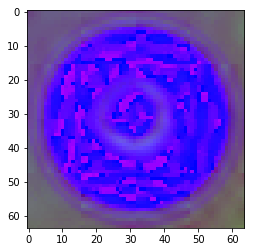

In [16]:
#one hot lookup
plt.imshow(x[-2][8])
print(y[-2])

# Models

Imported Model from this Tutorial 
    1. https://github.com/harvitronix/five-video-classification-methods

In [39]:
"""
A collection of models we'll use to attempt to classify videos.
"""
from keras.layers import Dense, Flatten, Dropout, ZeroPadding3D
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import TimeDistributed
from keras.layers.convolutional import (Conv2D, MaxPooling3D, Conv3D,
    MaxPooling2D)
from collections import deque
import sys

dim = 64,64,3

class ResearchModels():
    def __init__(self, nb_classes, model, seq_length,
                 saved_model=None, features_length=2048):
        """
        `model` = one of:
            lstm
            lrcn
            mlp
            conv_3d
            c3d
        `nb_classes` = the number of classes to predict
        `seq_length` = the length of our video sequences
        `saved_model` = the path to a saved Keras model to load
        """

        # Set defaults.
        self.seq_length = seq_length
        self.load_model = load_model
        self.saved_model = saved_model
        self.nb_classes = nb_classes
        self.feature_queue = deque()

        # Set the metrics. Only use top k if there's a need.
        metrics = ['accuracy']
        if self.nb_classes >= 10:
            metrics.append('top_k_categorical_accuracy')

        # Get the appropriate model.
        if self.saved_model is not None:
            print("Loading model %s" % self.saved_model)
            self.model = load_model(self.saved_model)
        elif model == 'lstm':
            print("Loading LSTM model.")
            self.input_shape = (seq_length, features_length)
            self.model = self.lstm()
        elif model == 'lrcn':
            print("Loading CNN-LSTM model.")
            self.input_shape = (seq_length, 64,64,3)
            self.model = self.lrcn()
        elif model == 'mlp':
            print("Loading simple MLP.")
            self.input_shape = (seq_length, features_length)
            self.model = self.mlp()
        elif model == 'conv_3d':
            print("Loading Conv3D")
            self.input_shape = (seq_length, 64,64,3)
            print(self.input_shape)
            self.model = self.conv_3d()
        elif model == 'c3d':
            print("Loading C3D")
            self.input_shape = (seq_length, 64,64,3)
            self.model = self.c3d()
        else:
            print("Unknown network.")
            sys.exit()

        # Now compile the network.
        optimizer = Adam(lr=1e-5, decay=1e-6)
        self.model.compile(loss='categorical_crossentropy', optimizer=optimizer,
                           metrics=metrics)

        print(self.model.summary())

    def lstm(self):
        """Build a simple LSTM network. We pass the extracted features from
        our CNN to this model predomenently."""
        # Model.
        model = Sequential()
        model.add(LSTM(2048, return_sequences=False,
                       input_shape=self.input_shape,
                       dropout=0.5))
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(self.nb_classes, activation='softmax'))

        return model

    def lrcn(self):
        """Build a CNN into RNN.
        Starting version from:
            https://github.com/udacity/self-driving-car/blob/master/
                steering-models/community-models/chauffeur/models.py
        Heavily influenced by VGG-16:
            https://arxiv.org/abs/1409.1556
        Also known as an LRCN:
            https://arxiv.org/pdf/1411.4389.pdf
        """
        model = Sequential()

        model.add(TimeDistributed(Conv2D(32, (7, 7), strides=(2, 2),
            activation='relu', padding='same'), input_shape=self.input_shape))
        model.add(TimeDistributed(Conv2D(32, (3,3),
            kernel_initializer="he_normal", activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

        model.add(TimeDistributed(Conv2D(64, (3,3),
            padding='same', activation='relu')))
        model.add(TimeDistributed(Conv2D(64, (3,3),
            padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3,3),
            padding='same', activation='relu')))
        model.add(TimeDistributed(Conv2D(128, (3,3),
            padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

        model.add(TimeDistributed(Conv2D(256, (3,3),
            padding='same', activation='relu')))
        model.add(TimeDistributed(Conv2D(256, (3,3),
            padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
        
        model.add(TimeDistributed(Conv2D(512, (3,3),
            padding='same', activation='relu')))
        model.add(TimeDistributed(Conv2D(512, (3,3),
            padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

        model.add(TimeDistributed(Flatten()))

        model.add(Dropout(0.5))
        model.add(LSTM(256, return_sequences=False, dropout=0.5))
        model.add(Dense(self.nb_classes, activation='softmax'))

        return model

    def mlp(self):
        """Build a simple MLP. It uses extracted features as the input
        because of the otherwise too-high dimensionality."""
        # Model.
        model = Sequential()
        model.add(Flatten(input_shape=self.input_shape))
        model.add(Dense(512))
        model.add(Dropout(0.5))
        model.add(Dense(512))
        model.add(Dropout(0.5))
        model.add(Dense(self.nb_classes, activation='softmax'))

        return model

    def conv_3d(self):
        """
        Build a 3D convolutional network, based loosely on C3D.
            https://arxiv.org/pdf/1412.0767.pdf
        """
        # Model.
        model = Sequential()
        model.add(Conv3D(
            32, (3,3,3), activation='relu', input_shape=self.input_shape
        ))
        model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))
        model.add(Conv3D(64, (3,3,3), activation='relu'))
        model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))
        model.add(Conv3D(128, (3,3,3), activation='relu'))
        model.add(Conv3D(128, (3,3,3), activation='relu'))
        model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))
        model.add(Conv3D(256, (2,2,2), activation='relu'))
        model.add(Conv3D(256, (2,2,2), activation='relu'))
        model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))

        model.add(Flatten())
        model.add(Dense(1024))
        model.add(Dropout(0.5))
        model.add(Dense(1024))
        model.add(Dropout(0.5))
        model.add(Dense(self.nb_classes, activation='softmax'))

        return model

    def c3d(self):
        """
        Build a 3D convolutional network, aka C3D.
            https://arxiv.org/pdf/1412.0767.pdf
        With thanks:
            https://gist.github.com/albertomontesg/d8b21a179c1e6cca0480ebdf292c34d2
        """
        model = Sequential()
        # 1st layer group
        model.add(Conv3D(64, 3, 3, 3, activation='relu',
                         border_mode='same', name='conv1',
                         subsample=(1, 1, 1),
                         input_shape=self.input_shape))
        model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2),
                               border_mode='valid', name='pool1'))
        # 2nd layer group
        model.add(Conv3D(128, 3, 3, 3, activation='relu',
                         border_mode='same', name='conv2',
                         subsample=(1, 1, 1)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2),
                               border_mode='valid', name='pool2'))
        # 3rd layer group
        model.add(Conv3D(256, 3, 3, 3, activation='relu',
                         border_mode='same', name='conv3a',
                         subsample=(1, 1, 1)))
        model.add(Conv3D(256, 3, 3, 3, activation='relu',
                         border_mode='same', name='conv3b',
                         subsample=(1, 1, 1)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2),
                               border_mode='valid', name='pool3'))
        # 4th layer group
        model.add(Conv3D(512, 3, 3, 3, activation='relu',
                         border_mode='same', name='conv4a',
                         subsample=(1, 1, 1)))
        model.add(Conv3D(512, 3, 3, 3, activation='relu',
                         border_mode='same', name='conv4b',
                         subsample=(1, 1, 1)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2),
                               border_mode='valid', name='pool4'))

        # 5th layer group
        model.add(Conv3D(512, 3, 3, 3, activation='relu',
                         border_mode='same', name='conv5a',
                         subsample=(1, 1, 1)))
        model.add(Conv3D(512, 3, 3, 3, activation='relu',
                         border_mode='same', name='conv5b',
                         subsample=(1, 1, 1)))
        model.add(ZeroPadding3D(padding=(0, 1, 1)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2),
                               border_mode='valid', name='pool5'))
        model.add(Flatten())

        # FC layers group
        model.add(Dense(4096, activation='relu', name='fc6'))
        model.add(Dropout(0.5))
        model.add(Dense(4096, activation='relu', name='fc7'))
        model.add(Dropout(0.5))
        model.add(Dense(self.nb_classes, activation='softmax'))

        return model

In [1]:
"""
Train our RNN on extracted features or images.
"""
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger
import time
import os.path

def train(data,data_type, seq_length, model, saved_model=None,
          class_limit=None, image_shape=None,
          load_to_memory=False, batch_size=32, nb_epoch=100):
    # Helper: Save the model.
    path = os.path.join("C:/Users/Surjith/PycharmProjects/opencvburnoutlamps/indData/",'data', 'checkpoints', model + '-' + data_type + '.{epoch:03d}-{val_loss:.3f}.hdf5')
    directory = os.path.dirname(path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    checkpointer = ModelCheckpoint(
        filepath=path,
        verbose=1,
        save_best_only=True)

    # Helper: TensorBoard
    path = os.path.join("C:/Users/Surjith/PycharmProjects/opencvburnoutlamps/indData/",'data', 'logs', model)
    directory = os.path.dirname(path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    tb = TensorBoard(log_dir=path)

    # Helper: Stop when we stop learning.
    early_stopper = EarlyStopping(patience=5)

    # Helper: Save results.
    timestamp = time.time()
    path = os.path.join("C:/Users/Surjith/PycharmProjects/opencvburnoutlamps/indData/",'data', 'logs', model+ '-' + 'training-' + \
        str(timestamp) + '.log')
    directory = os.path.dirname(path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    csv_logger = CSVLogger(path)
    
    # Get the model.
    rm = ResearchModels(12, model, 133, saved_model)
    
    x,y,x_test,y_test = data
    # Fit!
    if load_to_memory:
        # Use standard fit.
        rm.model.fit(
            x,
            y,
            batch_size=batch_size,
            validation_data=(x_test, y_test),
            verbose=1,
            callbacks=[tb, early_stopper, csv_logger],
            epochs=nb_epoch)

def main(data):
    """These are the main training settings. Set each before running
    this file."""
    # model can be one of lstm, lrcn, mlp, conv_3d, c3d
    model = 'conv_3d'
    saved_model = None  # None or weights file
    class_limit = None  # int, can be 1-101 or None
    seq_length = 133
    load_to_memory = True  # pre-load the sequences into memory
    batch_size = 32
    nb_epoch = 10

    # Chose images or features and image shape based on network.
    if model in ['conv_3d', 'c3d', 'lrcn']:
        data_type = 'images'
        image_shape = (64,64,3)
    elif model in ['lstm', 'mlp']:
        data_type = 'features'
        image_shape = None
    else:
        raise ValueError("Invalid model. See train.py for options.")

    train(data,data_type, seq_length, model, saved_model=saved_model,
          class_limit=class_limit, image_shape=image_shape,
          load_to_memory=load_to_memory, batch_size=batch_size, nb_epoch=nb_epoch)

Using TensorFlow backend.


In [2]:
data = np.array(x),np.array(y),np.array(x_test),np.array(y_test)

NameError: name 'np' is not defined

In [ ]:
print(np.array(x).shape)
main(data)

(329, 133, 64, 64, 3)
Loading Conv3D
(133, 64, 64, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_22 (Conv3D)           (None, 131, 62, 62, 32)   2624      
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 131, 31, 31, 32)   0         
_________________________________________________________________
conv3d_23 (Conv3D)           (None, 129, 29, 29, 64)   55360     
_________________________________________________________________
max_pooling3d_14 (MaxPooling (None, 129, 14, 14, 64)   0         
_________________________________________________________________
conv3d_24 (Conv3D)           (None, 127, 12, 12, 128)  221312    
_________________________________________________________________
conv3d_25 (Conv3D)           (None, 125, 10, 10, 128)  442496    
_________________________________________________________________
max_pooling3d_15 (MaxP

In [ ]:
print("hello")